<a href="https://colab.research.google.com/github/KamiriTech/Deep-Learning-/blob/main/Flowers_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

In [ ]:
#print tensorflow version
print(tf.__version__)

2.18.0


In [ ]:
# connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#define the path and split your data into training and validation split
dataset=tf.keras.preprocessing.image_dataset_from_directory(
        "/content/gdrive/MyDrive/Flower_photos")
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
        "/content/gdrive/MyDrive/Flower_photos",
        validation_split=0.2,
        subset="training",
        seed=123)
ds_validation = tf.keras.preprocessing.image_dataset_from_directory(
        "/content/gdrive/MyDrive/Flower_photos",
        validation_split=0.2,
        subset="validation",
        seed=123)

Found 3670 files belonging to 5 classes.
Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
# define the batch size and print the image labels
import tensorflow_datasets as tfds

batch_size = 64

dataset_name = dataset
class_names = dataset.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [ ]:
#Create a test set
val_batches = tf.data.experimental.cardinality(ds_validation)
test_dataset = ds_validation.take(val_batches // 5)
validation_dataset = ds_validation.skip(val_batches // 5)

In [ ]:
#reseize your images and standardize your data to make it for a nueral network
#Standardize your data
size = (512, 512)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_val= ds_validation.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = test_dataset.map(lambda image, label: (tf.image.resize(image, size), label))

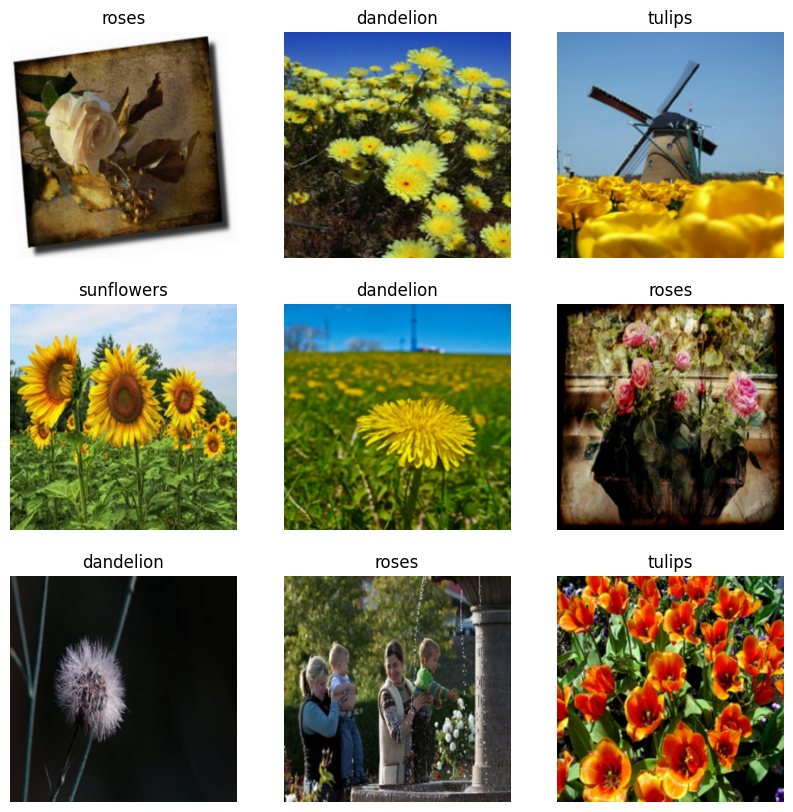

In [ ]:
# display the first 9 images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#do further preprocessing to increase the instances of images
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers


image = Sequential(
  [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(height_factor=(-0.2, -0.3), width_factor=(-0.2, -0.3), interpolation='bilinear'),
    layers.RandomContrast(factor=0.1),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    ],
    name="image",
)


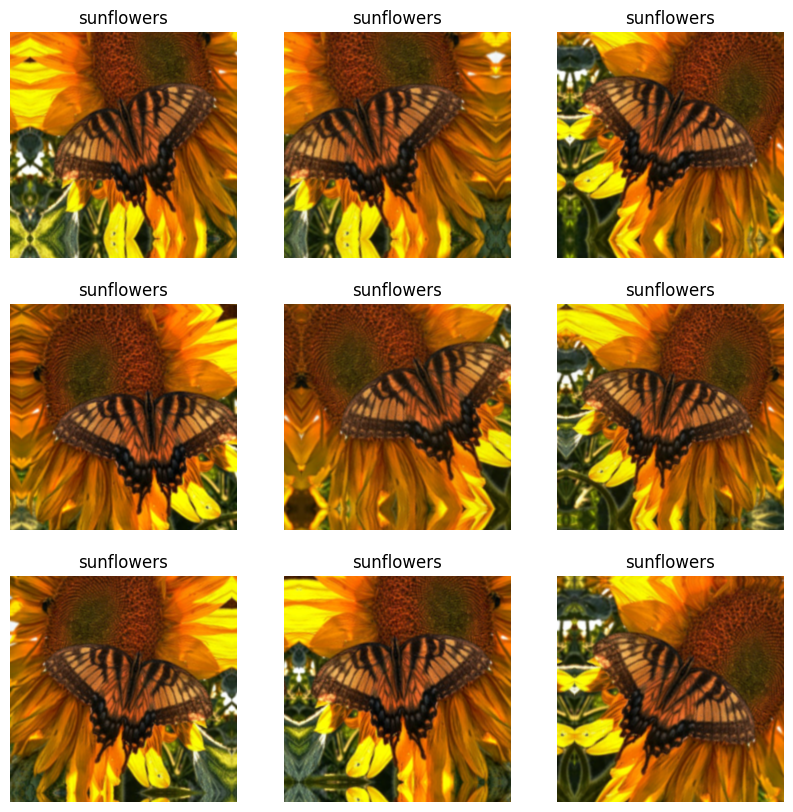

In [ ]:
import numpy as np

for images, labels in ds_train.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    def f(x):
      return int(x)
    f2 = np.vectorize(f)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = image(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(class_names[int(labels[0])])
        plt.axis("off")

In [ ]:
NUM_CLASSES=len(class_names)
print(NUM_CLASSES)

5


In [ ]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)

ds_train = ds_train.prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.map(input_preprocess)
ds_val = ds_val.prefetch(tf.data.AUTOTUNE)

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 3)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(5, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model

model.compile(
        optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision'),
        ]
    )

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 510, 510, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 255, 255, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 255, 255, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 253, 253, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 126, 126, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 126, 126, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1016064)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │   130,056,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,076,357 (496.20 MB)

 Trainable params: 130,076,357 (496.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
es = EarlyStopping(monitor = "val_accuracy", min_delta = 0.01, patience = 10,verbose = 1)

model_cp = ModelCheckpoint(filepath="/content/gdrive/MyDrive/Weights/myCNN_modelv1.keras", monitor = "val_accuracy",
                           save_best_only = True,
                           save_weights_only=False,
                           verbose = 1)

In [ ]:
# train the model
epochs = 50
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_val, callbacks=[model_cp, es], batch_size=64, verbose=1)

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.2492 - loss: 8098.2271 - precision: 0.2482 - recall: 0.1663
Epoch 1: val_accuracy improved from -inf to 0.24114, saving model to /content/gdrive/MyDrive/Weights/myCNN_modelv1.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 719ms/step - accuracy: 0.2493 - loss: 8036.6006 - precision: 0.2484 - recall: 0.1655 - val_accuracy: 0.2411 - val_loss: 1.6083 - val_precision: 0.2500 - val_recall: 0.0014
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.3100 - loss: 1.5804 - precision: 0.5322 - recall: 0.0193
Epoch 2: val_accuracy improved from 0.24114 to 0.25749, saving model to /content/gdrive/MyDrive/Weights/myCNN_modelv1.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 84s 919ms/step - accuracy: 0.3101 - loss: 1.5803 - precision: 0.5326 - recall: 0.0194 - val_accuracy: 0.2575 - val_loss: 1.6130 - val_precision: 0.4286 - val_recall: 0.0041
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.3936 - loss: 1.4921 - precision: 0.73

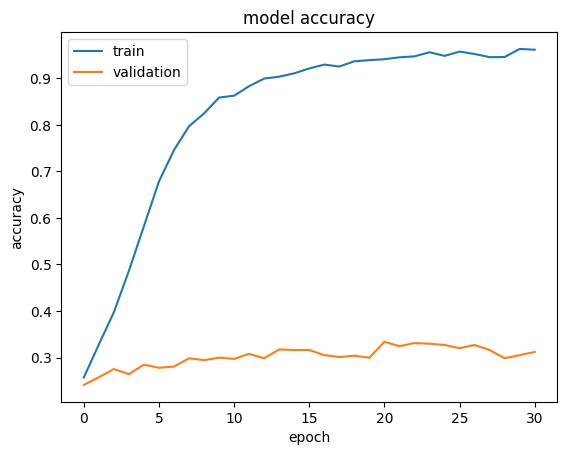

In [ ]:
# Visualize the training and validation curves
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

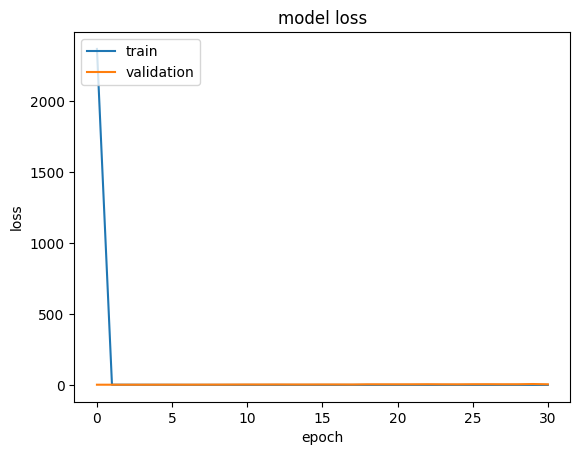

In [ ]:
# Visualize the training and validation curves
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

In [ ]:
test=ds_test

loss, accuracy, precision, recall =  model.evaluate(test)
print('Test accuracy :', accuracy)
print('Precision :', precision)
print('recall :', recall)



4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.2677 - loss: 4.3453 - precision: 0.2862 - recall: 0.2458
Test accuracy : 0.234375
Precision : 0.203125
recall : 0.2429906576871872


# Model 2

In [ ]:
from tensorflow.keras import layers, models, regularizers

model2 = models.Sequential([
    # First Convolution Block
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    # Second Convolution Block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    # Third Convolution Block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    # Global Average Pooling
    layers.GlobalAveragePooling2D(),

    # Fully Connected Layer
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),

    # Output Layer
    layers.Dense(5, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model

model2.compile(
        optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision'),
        ]
    )

In [ ]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,301 (434.77 KB)

 Trainable params: 110,853 (433.02 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
es = EarlyStopping(monitor = "val_accuracy", min_delta = 0.01, patience = 10,verbose = 1)

model_cp = ModelCheckpoint(filepath="/content/gdrive/MyDrive/Weights/myCNN_modelv2.keras", monitor = "val_accuracy",
                           save_best_only = True,
                           save_weights_only=False,
                           verbose = 1)

In [ ]:
# train the model
epochs = 50
hist = model2.fit(ds_train, epochs=epochs, validation_data=ds_val, callbacks=[model_cp, es], batch_size=64, verbose=1)

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.4167 - loss: 1.5651 - precision: 0.5048 - recall: 0.2046
Epoch 1: val_accuracy improved from -inf to 0.47548, saving model to /content/gdrive/MyDrive/Weights/myCNN_modelv2.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 86s 678ms/step - accuracy: 0.4171 - loss: 1.5640 - precision: 0.5053 - recall: 0.2050 - val_accuracy: 0.4755 - val_loss: 1.3756 - val_precision: 0.6343 - val_recall: 0.2316
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.5164 - loss: 1.2967 - precision: 0.6373 - recall: 0.3029
Epoch 2: val_accuracy improved from 0.47548 to 0.51907, saving model to /content/gdrive/MyDrive/Weights/myCNN_modelv2.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 93s 362ms/step - accuracy: 0.5164 - loss: 1.2966 - precision: 0.6373 - recall: 0.3031 - val_accuracy: 0.5191 - val_loss: 1.2859 - val_precision: 0.6433 - val_recall: 0.3120
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.5578 - loss: 1.2043 - precision: 0.6638 - r

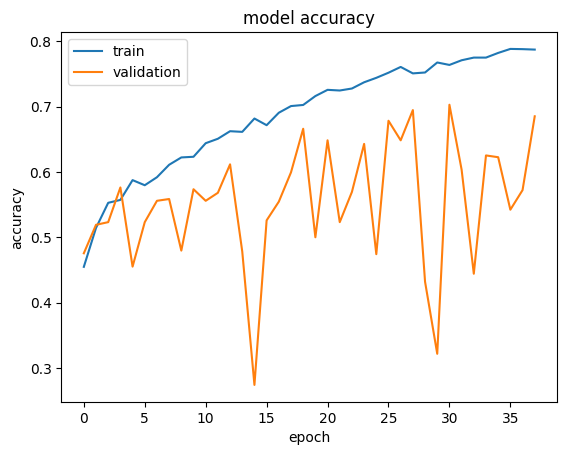

In [ ]:
# Visualize the training and validation curves
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

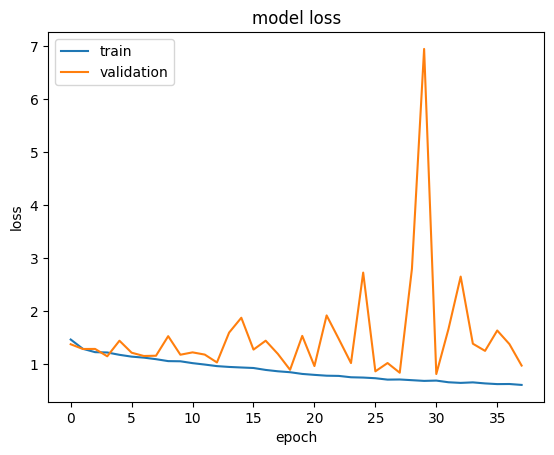

In [ ]:
# Visualize the training and validation curves
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

In [ ]:
test=ds_test

loss, accuracy, precision, recall =  model2.evaluate(test)
print('Test accuracy :', accuracy)
print('Precision :', precision)
print('recall :', recall)



4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 0.6865 - loss: 1.1531 - precision: 0.7342 - recall: 0.6458
Test accuracy : 0.6640625
Precision : 0.6171875
recall : 0.7117117047309875
